HHU Deep Learning, SS2023/24, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 08 - DINO (2-week exercise)
---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. 

This is a **two week exercise**. If we feel like you have genuinely tried to solve the exercise, you will receive **2** points for this assignment, regardless of the quality of your solution.



## <center> DUE FRIDAY 14.06.2024  </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/bNLoqWeVluyl1Hd](https://uni-duesseldorf.sciebo.de/s/bNLoqWeVluyl1Hd)

---
# Introduction

DINO (self-**di**stillation with **no** labels) is a self-supervised learning method in which the output of a student model is trained to match the soft pseudo-labels produced by a teacher network.
The teacher network is an exponential moving average (EMA) of the student network.
For more information see the [original paper](https://arxiv.org/abs/2104.14294).

In this exercise you will implement and train a DINO model on a medical dataset, the PathMNIST dataset from [medmnist](https://medmnist.com/) consisting of low resolution images of various colon pathologies.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from timm.models.vision_transformer import VisionTransformer
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Union, Optional
import os
from pathlib import Path

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Part I. The model

We use a very small Vision Transformer (ViT) for relatively fast training.

In [3]:
# Since we work on small images (28x28) we need a small patch size
vit_tiny_args = dict(patch_size=4, embed_dim=192, depth=12, num_heads=3, img_size=28, in_chans=3, num_classes=0,  pre_norm=True)
def vit_tiny():
    return VisionTransformer(**vit_tiny_args)

In [4]:
# Less than 6 million parameters
sum(p.numel() for p in vit_tiny().parameters() if p.requires_grad) / 1e6

5.358144

### Implement the DINO head
Like SimCLR, DINO uses a MLP head to project the output of the ViT to a output space.
Unlike SimCLR, the output dimension of the MLP can be much larger than the input dimension and is interpreted as pseudo label assignments.

The DINO head has some peculiarities:
- The first layers of the head is a `nlayers` MLP with GELU activations (but no activation on the last layer), with input dimension `in_dim`, hidden dimensions `hidden_dim` and output dimension `bottleneck_dim`.
Since the output dimension of the DINO head is often quite large (e.g. 65K for ImageNet), the bottleneck dimension reduces the number of parameters in the last layer and allows a deeper MLP.
- After this, the output is projected to the unit sphere (i.e. the output is normalized to unit length)
- The last layer is a fully connected layer from `bottleneck_dim` to `out_dim`. This layer is weight normalized ([https://arxiv.org/abs/1602.07868](https://arxiv.org/abs/1602.07868)) which means that the direction and lengths of the columns of the weight matrix are decoupled and stored in different paramters. This can improve stability and speed of training. The weight normalization is implemented in `nn.utils.weight_norm`.
Make sure that the length of these vectors (`weight_g`) are initialized to 1 and not trained.

In [110]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, nlayers=3, hidden_dim=512, bottleneck_dim=128):
        super().__init__()
        assert nlayers >= 1
        ### START CODE HERE ### (≈ 10 lines of code)
        layers = []
        for i in range(nlayers):
            layer_input_dim = in_dim if i == 0 else hidden_dim
            layer_output_dim = bottleneck_dim if i == nlayers - 1 else hidden_dim
            layers.append(nn.Linear(layer_input_dim, layer_output_dim))
            if i < nlayers - 1:
                layers.append(nn.GELU())
        self.layers = nn.Sequential(*layers)
        self.weight_norm = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.weight_norm.weight_g.requires_grad = False
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈ 3 lines of code)
        x = self.layers(x)
        x = nn.functional.normalize(x)
        x = self.weight_norm(x)
        return x
        ### END CODE HERE ###

def test_head():
    hparams = [
        (10, 20),
        (64, 32, 4, 256, 16),
        (20, 10, 1)
    ]
    num_params = [
        336512,
        152848,
        3968]
    for p, s in zip(hparams, num_params):
        head = DINOHead(*p)
        assert sum(p.numel() for p in head.parameters() if p.requires_grad) == s
        y = head(torch.randn(32, p[0]))
        assert y.shape == (32, p[1])
    print("Head test successful")

test_head()

Head test successful


Next, we wrap the ViT and the DINO head in a single model.
We also provide an EMA wrapper like in previous exercises.

In [6]:
class ViTTinyDINO(nn.Module):

    def __init__(self, out_dim):
        super().__init__()
        self.encoder = vit_tiny()
        in_dim = 192 # Output dimension of the vit_tiny
        # Empirically values like these work quite well
        self.head = DINOHead(
            in_dim=in_dim,
            out_dim=out_dim,
            nlayers=3,
            hidden_dim=in_dim * 2,
            bottleneck_dim=in_dim // 2)

    def forward(self, x):
        return self.head(self.encoder(x))

In [7]:
class EMAWrapper(nn.Module):

    def __init__(self, student, teacher, momentum=0.992):
        super().__init__()
        self.momentum = momentum
        teacher.load_state_dict(student.state_dict())
        self.model = teacher
        for p in self.parameters():
            p.requires_grad = False

    def update(self, student):
        for name, param in self.model.named_parameters():
            student_param = student.state_dict()[name]
            param.data *= self.momentum
            param.data += (1 - self.momentum) * student_param

    def forward(self, x):
        return self.model(x)

# Part II. The Loss Function

Implement the DINO loss function.
Remember that the DINO loss uses *centering* and *sharpening*.
For the centering you need to save the current center in a tensor (you should use `register_buffer` in the `__init__ `function for this).
For the sharpening you need to divide the ouput of the heads by the appropriate temperatures.

The DINO loss is the mean of the cross entropy losses between the student output (local + global views) and the teacher output (global views only).
However, do not compute the cross entropy loss for outputs of the student and teacher that correspond to the same view.

The input to the loss function will be flattened in the first dimension:
`teacher_output` has shape `(batch_size * num_global, out_dim)` and `num_global` entries in a row correspond to the global views of the same image.
You will need to group them somehow to compute the loss between views.
One way to achieve this is using `torch.chunk`.

In [37]:
class DINOLoss(nn.Module):

    def __init__(self,
                 out_dim,
                 num_global=2,
                 num_local=2,
                 student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.num_global = num_global
        self.num_local = num_local
        self.student_temp = student_temp
        self.center_momentum = center_momentum

        ### START CODE HERE ### (≈ 1 lines of code)
        # center buffer for global and local features
        self.register_buffer("center", torch.zeros(1, out_dim))
        ### END CODE HERE ###


    @torch.no_grad()
    def _update_center(self, teacher_output):
        """
        Update the center used for centering the outputs using exponential moving average.
        Args:
            teacher_output: Tensor of shape (batch_size * num_global, out_dim)
        """
        ## START CODE HERE ### (≈ 2 lines of code)
        # Compute the mean of the teacher output
        new_center = teacher_output.mean(dim=0)
        # Update the center
        self.center = self.center * self.center_momentum + new_center * (1 - self.center_momentum)
        ### END CODE HERE ###


    def forward(self, student_output, teacher_output, teacher_temp):
        """
        Compute the DINO loss given the outputs of the student and teacher networks.
        Args:
            student_output: Tensor of shape (batch_size * (num_global + num_local), out_dim)
            teacher_output: Tensor of shape (batch_size * num_global, out_dim)
            teacher_temp: Teacher temperature for this step

        Returns: scalar tensor, the loss value
        """
        # Don't forgot the centering and sharpening terms, as well as to update the center
        ### START CODE HERE ### (≈ 15 lines of code)
        t_output_clone = teacher_output
        teacher_output = teacher_output - self.center
        self._update_center(t_output_clone)
        teacher_output = teacher_output/teacher_temp
        teacher_output = nn.functional.softmax(teacher_output, dim=-1)

        student_output = student_output/self.student_temp
        student_output = nn.functional.softmax(student_output, dim=-1)

        student_chunks = torch.chunk(student_output, self.num_global + self.num_local, dim=0)
        teacher_chunks = torch.chunk(teacher_output, self.num_global, dim=0)

        total_loss = 0
        num_terms = 0

        for i, student_chunk in enumerate(student_chunks):
            for j, teacher_chunk in enumerate(teacher_chunks):
                if i<=j: continue
                loss = torch.sum(-teacher_chunk * torch.log(student_chunk + 1e-6), dim=-1).mean()
                total_loss += loss
                num_terms += 1

        total_loss /= num_terms

        return total_loss
        ### END CODE HERE ###

from functools import partial

def test_dinoloss():
    loss = DINOLoss(out_dim=8, num_global=2, num_local=3, student_temp=0.1, center_momentum=0.5)
    student_output = torch.linspace(-1, 1, 160).view(5*4, 8)
    teacher_output = torch.linspace(0, 2, 64).view(2*4, 8)

    c0 = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0.])
    c1 = torch.tensor([0.4444, 0.4603, 0.4762, 0.4921, 0.5079, 0.5238, 0.5397, 0.5556])
    c2 = torch.tensor([0.6667, 0.6905, 0.7143, 0.7381, 0.7619, 0.7857, 0.8095, 0.8333])
    c3 = torch.tensor([0.7778, 0.8056, 0.8333, 0.8611, 0.8889, 0.9167, 0.9444, 0.9722])

    t1, t2, t3 = [0.05, 0.08, 0.1]
    l1 = torch.tensor(1.8159)
    l2 = torch.tensor(1.9949)
    l3 = torch.tensor(2.0686)

    close = partial(torch.allclose, atol=1e-4, rtol=1e-4)

    assert close(loss.center, c0)
    for c, l, t in zip([c1, c2, c3], [l1, l2, l3], [t1, t2, t3]):
        assert close(loss(student_output, teacher_output, teacher_temp=t), l)
        assert close(loss.center, c)
    print("Loss test successful!")

test_dinoloss()

Loss test successful!


# Part III. The Dataset and Augmentations

[medmnist](https://medmnist.com/) provides a number of medical imaging datasets and is available as a pip package.

In [38]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [39]:
import medmnist

In [40]:
train_set = medmnist.PathMNIST(split='train', download=True, transform=transforms.ToTensor())
train_set

Using downloaded and verified file: /home/hongli/.medmnist/pathmnist.npz


Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/hongli/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-

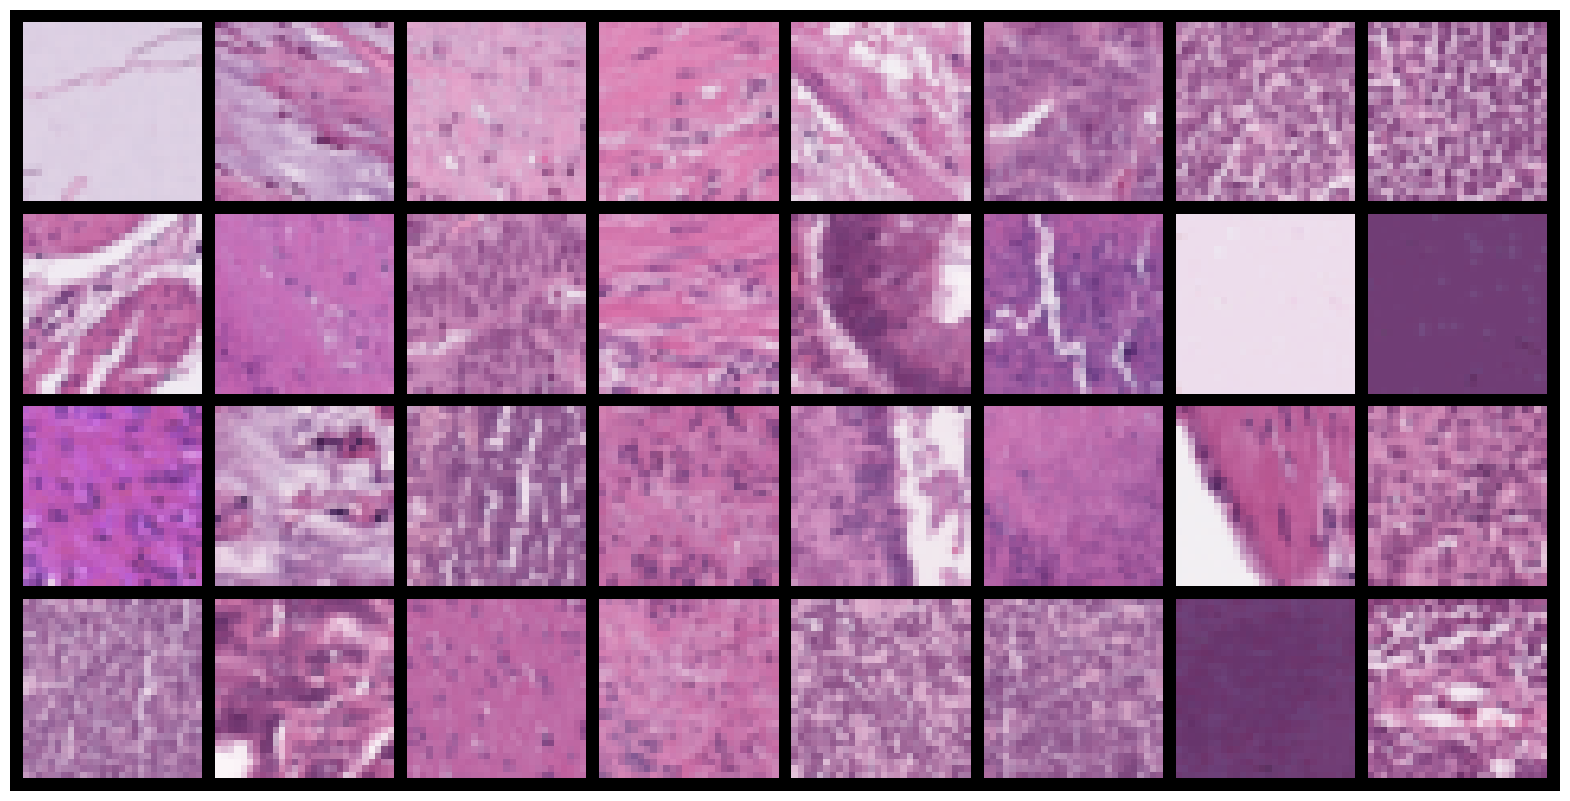

In [41]:
from torchvision.utils import make_grid
imgs = [train_set[i][0] for i in range(32)]
grid = make_grid(imgs, nrow=8)
plt.figure(figsize=(20, 15))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))

### Local and Global Views

The DINO paper uses a combination of local and global views of the images.
To enforce a local-global correspondence, the local views (only seen by the student) are random crops of the images and the global views are the entire images.

We will use very similar augmentations to the paper. In particular, we will have three types of augmentations:
- **Global 1**:
    - Color jitter with probability 80%
    - Horizontal flip with probability 50%
    - Vertical flip with probability 50%
    - Gaussian blur with probability 100%
- **Global 2**:
    - Color jitter with probability 80%
    - Horizontal flip with probability 50%
    - Vertical flip with probability 50%
    - Gaussian blur with probability 10%
    - Solarization (threshold 0.5) with probability 20%
- **Local**:
    - Color jitter with probability 80%
    - Horizontal flip with probability 50%
    - Vertical flip with probability 50%
    - Gaussian blur with probability 50%
    - Random sized crop of size between 0.2 and 0.8 of the original image size with probability 100%

The augmentations are applied in the order listed above. Normalization is applied to all views after the augmentations.
In the `__getitem__` method the augmentations are applied to an image.
Global 1 and Global 2 augmentations are applied at least once, the other `num_global - 2` times they are chosen randomly.
The local augmentations are applied `num_local` times.
All the augmentations are stacked together resulting in a tensor of shape `(num_global + num_local, c, h, w)`.

Since these images are quite different from ImageNet, other augmentations might be more appropriate.

In [42]:
class LocalGlobalPathMNIST(medmnist.PathMNIST):

    # Precomputed from the PathMNIST train set
    NORMALIZE = transforms.Normalize(
        std=[0.1237, 0.1768, 0.1244],
        mean=[0.7405, 0.5330, 0.7058],
    )

    def __init__(self, split='train', num_local=2, num_global=2):
        super().__init__(split=split)
        assert num_local >= 1
        assert num_global >= 2
        self.num_local = num_local
        self.num_global = num_global

        jitter = transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)
        gaussian_blur = transforms.GaussianBlur(5, sigma=(0.1, 1.0))

        ### START CODE HERE ### (≈ 25 lines of code)
        # Define the global and local transforms
        self.global_t1 = transforms.Compose([
            jitter,
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            gaussian_blur,
            transforms.ToTensor(),
            self.NORMALIZE])
        self.global_t2 = transforms.Compose([
            jitter,
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            gaussian_blur,
            transforms.RandomSolarize(0.5, 0.2),
            transforms.ToTensor(),
            self.NORMALIZE,])
        self.local = transforms.Compose([
            jitter,
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            gaussian_blur,
            transforms.RandomResizedCrop(28, scale=(0.2, 0.8)),
            transforms.ToTensor(),
            self.NORMALIZE,])
        ### END CODE HERE ###

    def __getitem__(self, idx):
        """
        Gets views of the image at the given index.

        Returns: Tensor of shape (num_global + num_local, 3, 28, 28)
        """
        img, _ = super().__getitem__(idx)
        ### START CODE HERE ### (≈ 9 lines of code)
        # Apply the global and local transforms
        augments = []
        augments.append(self.global_t1(img))
        augments.append(self.global_t2(img))

        for i in range(self.num_global - 2):
            if torch.randint(high = 1, size=(1,)).item():
                augments.append(self.global_t1(img))
            else:
                augments.append(self.global_t2(img))

        for i in range(self.num_local):
            augments.append(self.local(img))

        return torch.stack(augments)
        ### END CODE HERE ###

def test_local_global():
    dataset = LocalGlobalPathMNIST(num_local=6, num_global=2)
    imgs = [dataset[i] for i in range(32)]
    assert all([img.shape == (8, 3, 28, 28) for img in imgs])

    dataset = LocalGlobalPathMNIST(num_local=4, num_global=3)
    imgs = [dataset[i] for i in range(32)]
    assert all([img.shape == (7, 3, 28, 28) for img in imgs])
    print("Local and global views test successful")

test_local_global()

Local and global views test successful


Let's look at some examples of local and global views.
Each row is a different image. The first two columns are the global views and the last 2 columns are the local views.

In [43]:
dataset =  LocalGlobalPathMNIST()
loader = DataLoader(dataset, batch_size=4)
imgs = next(iter(loader))

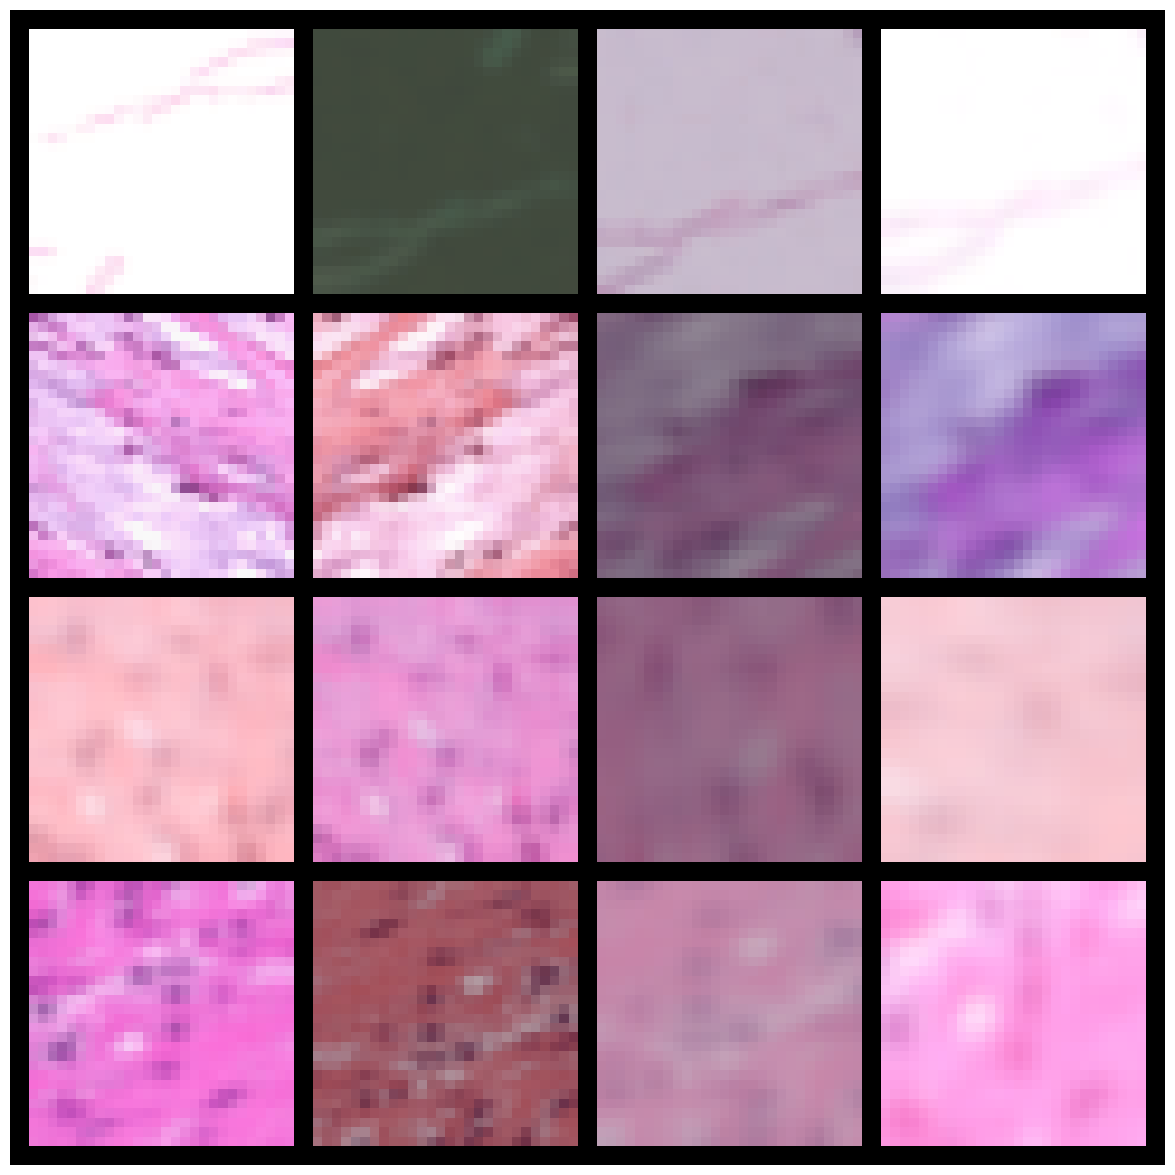

In [44]:
mean, std = LocalGlobalPathMNIST.NORMALIZE.mean, LocalGlobalPathMNIST.NORMALIZE.std
unnormalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)


imgs = imgs.view(-1, 3, 28, 28)
imgs = unnormalize(imgs).clamp(0, 1)
grid = make_grid(imgs, nrow=4)
plt.figure(figsize=(20, 15))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))

# Part IV. Training

DINO training uses cosine schedulers not only for the learning rate, but also for the weight decay, the teacher EMA momentum and the teacher temperature.
For more information about weight decay scheduling see https://arxiv.org/abs/2011.11152, https://arxiv.org/abs/2006.08643.

These extra tricks are not necessary for training the tiny ViT for a small amount of time, but we will use them for the exercise's sake.
Familiarize yourself with the code below.

In [58]:
def cosine_schedule(base_value, final_value, total_steps, warmup_steps=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    if warmup_steps > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_steps)

    iters = np.arange(total_steps - warmup_steps)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == total_steps
    return schedule

class CosineSchedule:

    def __init__(
            self,
            base_value: float,
            final_value: Optional[float] = None,
            warmup_pct: float = 0,
            start_warmup_value: float = 0):
        self.schedule = None
        self.total_steps = None

        self.base_value = base_value
        self.final_value = final_value if final_value is not None else base_value
        self.warmup_pct = warmup_pct
        self.start_warmup_value = start_warmup_value

    def init(self, total_steps: int):
        self.schedule = cosine_schedule(
            base_value=self.base_value,
            final_value=self.final_value,
            total_steps=total_steps,
            warmup_steps=int(self.warmup_pct * total_steps),
            start_warmup_value=self.start_warmup_value
        )
        self.total_steps = total_steps

    def __call__(self, step):
        if self.schedule is None:
            raise ValueError("Schedule not initialized")
        step = min(step, self.total_steps - 1)
        return self.schedule[step]

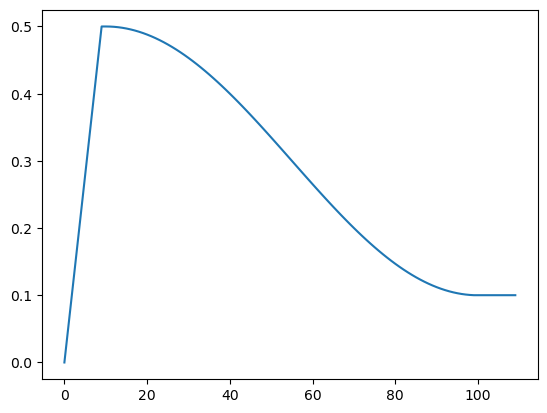

In [59]:
# Linear warmup from 0 to 0.5 in 10% of the steps, then cosine decay to 0.1
schedule = CosineSchedule(0.5, 0.1, 0.1, 0)
# 100 steps total
schedule.init(100)
plt.plot([schedule(i) for i in range(110)])

We will wrap the training logic in a class.
The trainer will only see the global views, you will need to slice the batch appropriately.

In [136]:
class DINOTrainer(nn.Module):
    def __init__(
            self,
            dataset: LocalGlobalPathMNIST,
            lr_schedule: Callable[[int], float],
            wd_schedule: Callable[[int], float],
            teacher_temp_schedule: Callable[[int], float],
            teacher_ema_schedule: Callable[[int], float],
            student_temp: float = 0.1,
            batch_size: int = 256,
            out_dim: int = 256,
            ckpt_name: Union[str, os.PathLike] = "checkpoint.pth"):
        super().__init__()

        self.ckpt_name = Path(ckpt_name)

        self.epoch = 0
        self.steps = 0

        self.dataset = dataset
        self.batch_size = batch_size
        self.out_dim = out_dim

        self.lr_schedule = lr_schedule
        self.wd_schedule = wd_schedule
        self.teacher_temp_schedule = teacher_temp_schedule
        self.teacher_ema_schedule = teacher_ema_schedule

        self.num_local = dataset.num_local
        self.num_global = dataset.num_global

        self.data_loader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=True
        )

        # Initialize the student and the teacher, optimizer and the loss. Don't forget the EMA wrapper!
        ### START CODE HERE ### (≈ 5 lines of code)
        self.student = ViTTinyDINO(out_dim)
        self.teacher = ViTTinyDINO(out_dim)
        self.teacher = EMAWrapper(self.student, self.teacher)
        self.optim = torch.optim.Adam(self.student.parameters())
        self.dino_loss = DINOLoss(out_dim, self.num_global, self.num_local)
        ### END CODE HERE ###


    @property
    def device(self):
        return next(self.student.parameters()).device

    def train_one_epoch(self, epoch):
        self.student.train()
        self.teacher.train()
        num_global = self.dataset.num_global
        with tqdm(self.data_loader, desc=f'Epoch: {epoch}') as pbar:
            for batch in pbar:
                batch = batch.transpose(0, 1).contiguous()
                # batch has shape (num_global + num_local, bs, c, h, w)
                c, h, w = batch.shape[-3:]

                # Apply the various schedules, compute the student and teacher output and the loss.
                # Update the student using the optimizer and the teacher using the EMA wrapper functionality.
                ### START CODE HERE ### (≈ 15 lines of code)
                lr = self.lr_schedule(self.steps)
                wd = self.wd_schedule(self.steps)
                teacher_temp = self.teacher_temp_schedule(self.steps)
                self.teacher.step = self.teacher_ema_schedule(self.steps)

                for param_group in self.optim.param_groups:
                    param_group['lr'] = lr
                    param_group['weight_decay'] = wd

                student_output = self.student(batch.view(-1, c, h, w).to(self.device))
                teacher_output = self.teacher(batch[:num_global].view(-1, c, h, w).to(self.device))

                loss = self.dino_loss(student_output, teacher_output, teacher_temp)

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                self.teacher.update(self.student)
                ### END CODE HERE ###

                pbar.set_postfix(loss=loss.item())
                self.steps += 1

    def save(self):
        torch.save(dict(
            student=self.student.state_dict(),
            teacher=self.teacher.state_dict(),
            optim=self.optim.state_dict(),
            dino_loss=self.dino_loss.state_dict(),
            epoch=self.epoch,
            steps=self.steps,
        ), self.ckpt_name)

    def load(self):
        print('Loading checkpoint', self.ckpt_name)
        ckpt = torch.load(self.ckpt_name)
        self.student.load_state_dict(ckpt['student'])
        self.teacher.load_state_dict(ckpt['teacher'])
        self.optim.load_state_dict(ckpt['optim'])
        self.dino_loss.load_state_dict(ckpt['dino_loss'])
        self.epoch = ckpt['epoch']
        self.steps = ckpt['steps']

    def train(self, num_epochs: int, resume=False):
        self.epoch = 0
        self.steps = 0

        total_iters = len(self.data_loader) * num_epochs
        self.lr_schedule.init(total_iters)
        self.wd_schedule.init(total_iters)
        self.teacher_temp_schedule.init(total_iters)
        self.teacher_ema_schedule.init(total_iters)

        if resume and self.ckpt_name.exists():
            self.load()

        while self.epoch < num_epochs:
            self.train_one_epoch(self.epoch)
            self.epoch += 1
            self.save()

        return self.teacher.model.encoder

Define the schedules for the various hyperparameters.
- The weight decay follows a cosine schedule from 0.02 to 0.04.
- The learning rate follows a cosine schedule from 5e-4 to 2e-4 with a warmup of 10% of the total number of iterations.
- The teacher temperature warms up from 0.04 to 0.07 with a warmup of 10% of the total number of iterations and then stays constant.
- The teacher EMA momentum follows a cosine schedule from 0.992 to 0.996.

In [137]:
### START CODE HERE ### (≈ 5 lines of code)
wd_schedule = CosineSchedule(0.02, 0.04)
lr_schedule = CosineSchedule(5e-4, 2e-6, warmup_pct=0.1)
teacher_temp_schedule = CosineSchedule(0.04, 0.07, warmup_pct=0.1)
ema_schedule = CosineSchedule(0.992, 0.996)
### END CODE HERE ###

In [138]:
NUM_LOCAL = 2
NUM_GLOBAL = 2
BATCH_SIZE = 32
OUT_DIM = 256
NUM_EPOCHS = 2

In [139]:
dataset = LocalGlobalPathMNIST(
    num_local=NUM_LOCAL,
    num_global=NUM_GLOBAL
)

In [140]:
next(iter(dataset)).shape

torch.Size([4, 3, 28, 28])

In [141]:
trainer = DINOTrainer(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    out_dim=OUT_DIM,
    lr_schedule=lr_schedule,
    wd_schedule=wd_schedule,
    teacher_temp_schedule=teacher_temp_schedule,
    teacher_ema_schedule=ema_schedule).to(device)

# Launch training
This should take around ~45 minutes. The loss might decrease very slowly at the beginning of training.

- If this takes too long, feel free to interrupt the training, but try to run at least 5 epochs.

In [142]:
encoder = trainer.train(NUM_EPOCHS)

Epoch: 1: 100%|██████████| 2812/2812 [06:06<00:00,  7.66it/s, loss=nan]


# Part V. Evaluation
As usual, we evaluate the model by computing the knn accuracy on the test set.
The encoder returned by the trainer is the teacher ViT without the head.

In [143]:
train_set = medmnist.PathMNIST(split='train', download=True,
                               transform=transforms.Compose([transforms.ToTensor(), LocalGlobalPathMNIST.NORMALIZE]))
test_set = medmnist.PathMNIST(split='test', download=True,
                              transform=transforms.Compose([transforms.ToTensor(), LocalGlobalPathMNIST.NORMALIZE]))

Using downloaded and verified file: /home/hongli/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/hongli/.medmnist/pathmnist.npz


In [144]:
@torch.no_grad()
def get_features(encoder, dataset, device):
    encoder.eval()
    loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
    features = []
    labels = []
    for image, label in tqdm(loader):
        image = image.to(device)
        features.append(encoder(image).cpu())
        labels.append(label.cpu())
    features = torch.cat(features)
    features /= features.norm(dim=-1, keepdim=True)
    labels = torch.cat(labels).squeeze()
    return features, labels

In [145]:
def eval_knn(encoder, train_set, test_set, device):
    train_features, train_labels = get_features(encoder, train_set, device)
    test_features, test_labels = get_features(encoder, test_set, device)
    nn_idc = (test_features @ train_features.T).argmax(dim=-1)
    preds = train_labels[nn_idc]
    return (preds == test_labels).float().mean()

You should get around 75% accuracy. This is not particularly good. In fact a small ResNet trained supervised on ImageNet will get around 80% accuracy. However, the DINO model can be improved by much longer training.

In [146]:
eval_knn(encoder, train_set, test_set, device)

100%|██████████| 29/29 [00:01<00:00, 23.68it/s]


tensor(0.1864)

# Part VI. Investigate the pseudo-label distribution

It the turns out, the pseudo labels (produced by the output of the projection head) are not uniformly distributed. Display the number of images assigned to each class in a histogram (tip: use `torch.bincount`). What do you observe? Why do you think this is the case?

<BarContainer object of 9 artists>

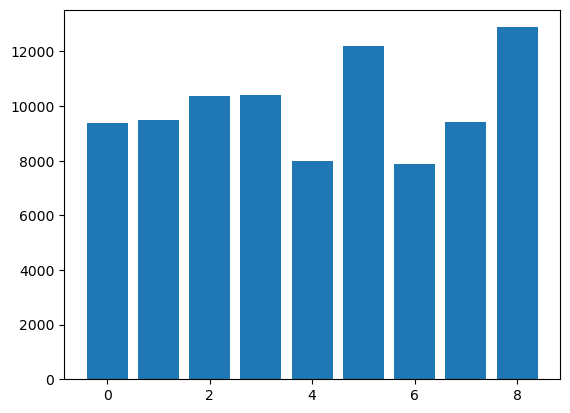

In [150]:
### START CODE HERE ### (≈ 5 lines of code)
features, labels = get_features(encoder, train_set, device)
counts = torch.bincount(labels)
plt.bar(torch.arange(len(counts)), counts)
plt.show()
### END CODE HERE ###